## Image segmentation - Knees

In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
import os

## Data

In [2]:
f2 = get_image_files('/work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded')
f2[0]

PosixPath('/work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded/1.2.840.113619.2.110.210419.20151005135942.2.9.12.1.jpg')

In [3]:
lb2 = get_image_files('/work2/05515/bflynn/frontera/knee_segmentation/knee_png_padded')
lb2[0]

PosixPath('/work2/05515/bflynn/frontera/knee_segmentation/knee_png_padded/1.2.840.113619.2.110.210419.20150928111451.2.6.12.1.png')

In [4]:
lbl_f = lb2[0]

In [5]:
lbl_f

PosixPath('/work2/05515/bflynn/frontera/knee_segmentation/knee_png_padded/1.2.840.113619.2.110.210419.20150928111451.2.6.12.1.png')

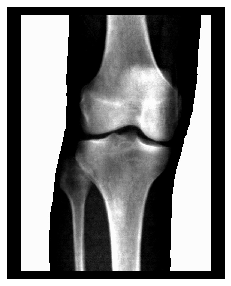

In [6]:
img_f2 = f2[0]
imgf2 = open_image(img_f2)
imgf2.show(figsize=(5,5))

In [7]:
label_path = Path('/work2/05515/bflynn/frontera/knee_segmentation/knee_png_padded')
label_path

PosixPath('/work2/05515/bflynn/frontera/knee_segmentation/knee_png_padded')

In [8]:
image_path = Path('/work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded')
image_path

PosixPath('/work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded')

# This is how to use the get function to convert jpg filename strings to png label strings

Remember - everything **MUST** be a PosixPath, use Pathlib library

In [9]:
img_f2

PosixPath('/work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded/1.2.840.113619.2.110.210419.20151005135942.2.9.12.1.jpg')

In [10]:
get_y_fn2 = lambda x: label_path/f'{x.stem}.png'
get_y_fn2(img_f2)

PosixPath('/work2/05515/bflynn/frontera/knee_segmentation/knee_png_padded/1.2.840.113619.2.110.210419.20151005135942.2.9.12.1.png')

In [11]:
print(get_y_fn2(img_f2))

/work2/05515/bflynn/frontera/knee_segmentation/knee_png_padded/1.2.840.113619.2.110.210419.20151005135942.2.9.12.1.png


Not a usual image file, **contains integers**. Must use open mask as opposed to open image, because we want to return integers, not floats. mask.show will automatically color code the image in some appropriate way. 

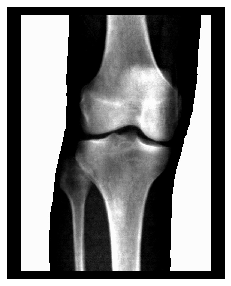

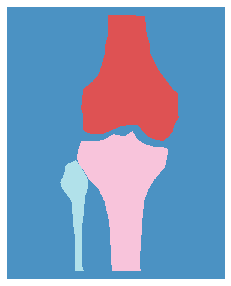

In [12]:
# Go to corresponding mask img
mask = open_mask(get_y_fn2(img_f2))
imgf2.show(figsize=(5,5))
mask.show(figsize=(5,5), alpha=0.8)

In [13]:
# Uncomment to see masks for images in dataset
# for file in f2[0:10]:
#     mask = open_mask(get_y_fn2(file))
#     mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1000,  800]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [15]:
codes1 = np.array(['Background', 'Femur', 'Tibia', 'Fibula']); codes1

array(['Background', 'Femur', 'Tibia', 'Fibula'], dtype='<U10')

Codes1 is an array that contains codes that correspond to different parts of the image. For example, 4 is in the top left corner of the tensor, corresponds to the top left portion of the image. If you count to index four in the codes array (remember to start from zero), see that building corresponds to 4. In the top left corner there is a building. 

## Datasets

In [16]:
size = src_size//2
# Using only half of the pixels!!!!!!!!!

free = gpu_mem_get_free_no_cache()
# smaller batch size, creating a classifier for every pixel, will take
# a lot more GPU
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16122MB of GPU RAM free


### Example ImageList object from previous notebook
```Python
image_data = (ImageList.from_df(data, path=path, cols="Filename")
                       .split_by_idx(val_fold_1)
                       .label_from_df(cols="Working")
                       .transform(tfms, size=size))

```

In [17]:
src = (SegmentationItemList.from_folder(image_path)
       .split_by_fname_file('validation.txt')
#        .split_none() # use this if you just want to look at data batches
       .label_from_func(get_y_fn2, classes=codes1))
# don't have every single pixel labeled with a string. Instead, have code numbers for each pixel
# and a corresponding file containing the label strings. More efficient.

In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=8)
        .normalize(imagenet_stats))
# sometimes we randomly flip an image, but what if we flip the independent
# variable image (original), but don't also flip the dependent (mask)
# tfm_y = true means whatever you do to the x or independent variable, do to 
# the y or dependent variable. 

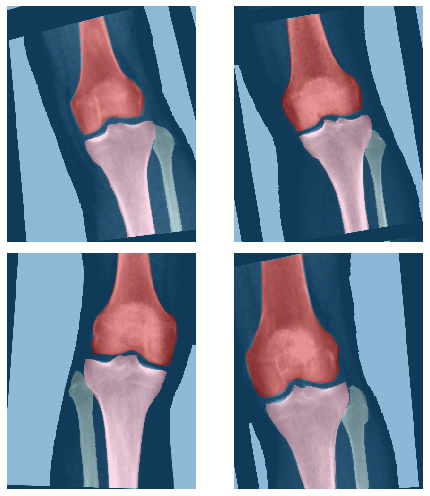

In [19]:
data.show_batch(2, figsize=(7,7))

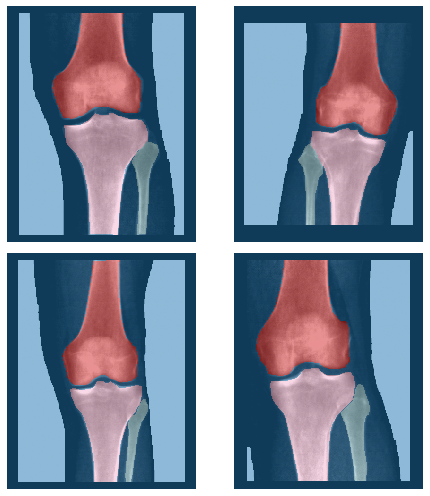

In [20]:
data.show_batch(2, figsize=(7,7), ds_type=DatasetType.Valid)

## Model

In [16]:
def mean_IU(eval_segm, gt_segm):
    
    
    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_, IU

def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")
        
def acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


In [17]:
metrics = [acc, mean_IU]

In [23]:
wd=1e-2 # weight decay

**For image segmentation, use unet_learner (not create_cnn).**

In [24]:
learn = unet_learner(data, models.resnet34, metrics=acc, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


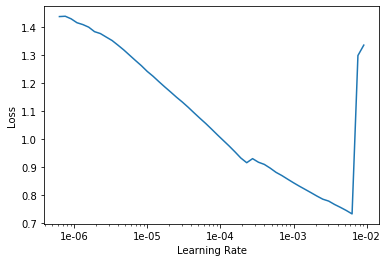

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
minlr = 3e-5
maxlr = 1e-4

In [27]:
learn.fit_one_cycle(12, slice(minlr, maxlr), pct_start=0.9)

epoch,train_loss,valid_loss,acc,time
0,1.266107,0.950420,0.737424,00:08
1,1.082834,0.850521,0.732156,00:05
2,0.977286,0.756506,0.734490,00:05
3,0.890061,0.645423,0.741244,00:05
4,0.809499,0.521221,0.843197,00:05
5,0.724288,0.328153,0.901676,00:05
6,0.653624,0.201599,0.942949,00:05
7,0.582776,0.196383,0.939291,00:05
8,0.519506,0.151962,0.951133,00:05
9,0.461192,0.092485,0.973504,00:05


In [28]:
learn.save('knees-1')

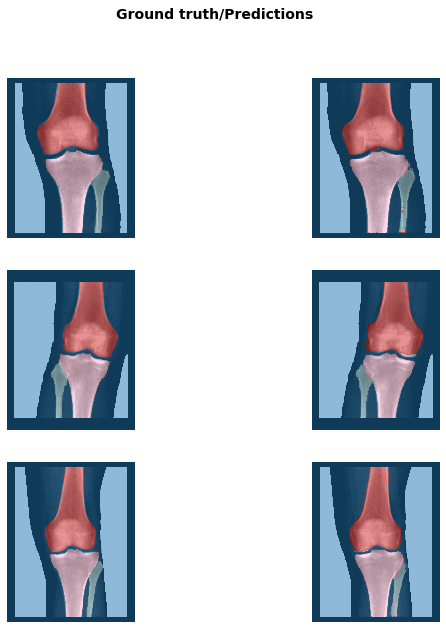

In [29]:
learn.show_results(rows=3, figsize=(10,10))

In [30]:
learn.unfreeze()

# Phase 2 - Use the full size of the image for training!

**U net - CNN that goes smaller, then goes bigger, making a U shape. Originally published for biomedical image segmentation, but also useful for a variety of other things. Presented at mic i, most cited paper from that conference.** 

**If you want to create an image segmentation model, use learner. create_unet instead of create_cnn.**

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [17]:
wd=1e-2
size = src_size
# Now using ALL of the pixels! That's why you need to decrease the batch 
# size - segmenting more pixels, will overload GPU if you don't reduce
# the batch size!

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16122MB of GPU RAM free


In [18]:
src = (SegmentationItemList.from_folder(image_path)
       .split_by_fname_file('validation.txt')
#        .split_none() # use this if you just want to look at data batches
       .label_from_func(get_y_fn2, classes=codes1))
# don't have every single pixel labeled with a string. Instead, have code numbers for each pixel
# and a corresponding file containing the label strings. More efficient.

In [19]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=1)
        .normalize(imagenet_stats))

In [20]:
learn = unet_learner(data, models.resnet34, metrics=acc, wd=wd)#.to_fp16()
# to_fp16() - get a model that trains in 16 bit precision. Need a recent GPU, but can 
# uses less GPU - called mixed precision floating point
# Jeremy found that using this caused his accuracy to increase
# Sometimes less precision helps model generalize a bit better
# if kernel dies, old drivers or too old graphics card

In [21]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (40 items)
x: SegmentationItemList
Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800)
y: SegmentationLabelList
ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800)
Path: /work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded;

Valid: LabelList (23 items)
x: SegmentationItemList
Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800)
y: SegmentationLabelList
ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800)
Path: /work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm

In [22]:
src_size

array([1000,  800])

# Try using even array for src_size

In [23]:
learn.load('knees-1')

Learner(data=ImageDataBunch;

Train: LabelList (40 items)
x: SegmentationItemList
Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800)
y: SegmentationLabelList
ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800)
Path: /work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded;

Valid: LabelList (23 items)
x: SegmentationItemList
Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800),Image (3, 1000, 800)
y: SegmentationLabelList
ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800),ImageSegment (1, 1000, 800)
Path: /work2/05515/bflynn/frontera/knee_segmentation/knee_jpg_padded;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm

In [24]:
learn.unfreeze()

**You want learning rate to decrease as you get closer to the end - want it to be fast while its getting to the right answer, and then right as its close to the target, want the learning rate to be slow so that the model doens't diverge and miss the right answer all together.**

In [25]:
minlr = 3e-5//400
maxlr = 1e-4//100

In [26]:
learn.fit_one_cycle(10, slice(minlr, maxlr), pct_start=0.8)

epoch,train_loss,valid_loss,acc,time
0,0.179537,0.152993,0.949502,00:22
1,0.201849,0.154090,0.948967,00:17
2,0.194806,0.168031,0.945668,00:17
3,0.189886,0.156045,0.948542,00:17
4,0.195124,0.163717,0.947530,00:17
5,0.198527,0.170214,0.945203,00:17
6,0.193695,0.162959,0.946064,00:17
7,0.215238,0.164947,0.946385,00:17
8,0.205575,0.167603,0.945413,00:17
9,0.202841,0.153669,0.949347,00:17


In [27]:
learn.save('knees-big1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


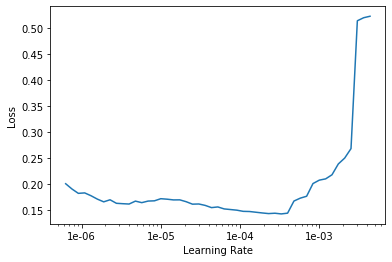

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
minlr = 1e-5
maxlr = 1e-4

In [30]:
learn.fit_one_cycle(10, slice(minlr, maxlr), pct_start=0.7)

epoch,train_loss,valid_loss,acc,time
0,0.185878,0.093261,0.966978,00:18
1,0.140265,0.060935,0.979387,00:17
2,0.108031,0.073439,0.974314,00:17
3,0.085680,0.040056,0.986159,00:17
4,0.078204,0.044042,0.985018,00:17
5,0.062403,0.036441,0.987064,00:17
6,0.049447,0.056066,0.981503,00:17
7,0.046881,0.029024,0.988890,00:17
8,0.040681,0.030456,0.988433,00:17
9,0.035751,0.027107,0.989273,00:17


In [31]:
learn.save('knees-big2')

In [32]:
learn.export("knee_segmentation.pkl")

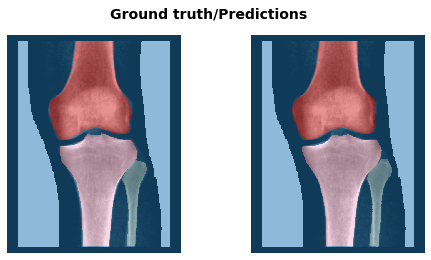

In [36]:
learn.show_results(rows=10)